### MLBootCamp V. Задача "Предсказание ССЗ". Решение на второе место

##### автор: Рим Шаяхметов

##### Данное довольно простое решение давало самый лучший локальный результат (mean + std), которого я смог добиться. Оно соответствует второму месту финального результата.

In [60]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import VotingClassifier
import pylab as pl

import gc

%matplotlib inline

In [38]:
train = pd.read_csv('train.csv', sep=';')
train.age = train.age/365.25
train.gender -= 1
del train['id']

In [39]:
test = pd.read_csv('test.csv', sep=';')
test.age = test.age/365.25
test.replace('None', np.NaN, inplace=True)
test.smoke = test.smoke.astype('float')
test.alco = test.alco.astype('float')
test.active = test.active.astype('float')
test.gender -= 1
del test['id']

In [40]:
y_train = train.cardio.values
del train['cardio']

#### Возраст был преобразован в "года" с помощью нахождения пиков 13 компонент гауссовской смеси, а затем разбиения каждого интервала пополам, чтобы одному "году" соответствовала половинка одной компоненты.

In [41]:
def guess_age_clusters():
    gm = BayesianGaussianMixture(n_components=13, random_state=30, max_iter=500, tol=0.0001)
    gm.fit(test.loc[test.age > 36, ['age']].append(train.loc[train.age > 36, ['age']]))
    centers = np.sort(gm.means_[:, 0])
    train.age.append(test.age).hist(bins=100)
    bins = [20] + list(np.array([[a, (a + b)/2] for a, b in zip(centers, centers[1:])]).flatten()) + [centers[-1], 66]
    for c in bins[1:-1]:
        pl.axvline(c, linewidth=0.5, c='g')
    return bins

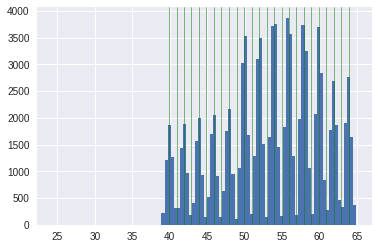

In [42]:
age_centers = guess_age_clusters()

In [43]:
def preprocess(train, test):
    data = train.append(test).reset_index(drop=True)
    train_loc, test_loc = data.iloc[:train.shape[0]].index, data.iloc[train.shape[0]:].index
    
    # PRESSURE 
    
    mask = (data.ap_hi == 1) & (data.ap_lo > 100)
    data.loc[mask, 'ap_hi'] = (
        data.loc[mask, 'ap_hi']*100 + (data.loc[mask, 'ap_lo']//100))
    data.loc[mask, 'ap_lo'] = (data.loc[mask, 'ap_lo'].mod(100)//10)*10
    data.loc[data.ap_hi == 14900, 'ap_hi'] = 140
    data.loc[data.ap_hi > 4000, 'ap_hi'] //= 100
    mask = (data.ap_lo == 0) & (data.ap_hi >= 300)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_hi']//10, data.loc[mask, 'ap_hi'].mod(10)*10
    data.loc[data.ap_hi.isin([400, 401]), 'ap_hi'] = 140
    data.loc[data.ap_hi == 701, 'ap_hi'] = 170
    data.loc[data.ap_hi == 1420, 'ap_hi'] = 140
    data.loc[data.ap_hi == 1620, 'ap_hi'] = 160
    data.loc[data.ap_hi.isin([1130,1110]), 'ap_hi'] = 110
    data.loc[data.ap_hi == 960, 'ap_hi'] = 90
    data.loc[data.ap_hi >= 300, 'ap_hi'] //= 10
    
    data.loc[data.ap_lo == 4100, 'ap_lo'] = 140
    data.loc[data.ap_lo == 10000, 'ap_lo'] = 100
    data.loc[data.ap_lo == 5700, 'ap_lo'] = 75
    data.loc[data.ap_lo == 6800, 'ap_lo'] = 80
    data.loc[data.ap_lo == 4700, 'ap_lo'] = 70
    data.loc[data.ap_lo == 1100, 'ap_lo'] = 110
    
    data.loc[data.ap_lo >= 4000, 'ap_lo'] = (data.loc[data.ap_lo >= 4000, 'ap_lo']//1000)*10
    data.loc[data.ap_lo == 1900, 'ap_lo'] = 90
    data.loc[data.ap_lo == 1211, 'ap_lo'] = 120
    data.loc[data.ap_lo >= 1200, 'ap_lo'] //= 10
    data.loc[data.ap_lo >= 1100, 'ap_lo'] = (data.loc[data.ap_lo >= 1100, 'ap_lo']//100)*10 
    data.loc[data.ap_lo >= 1000, 'ap_lo'] = 100
    data.loc[data.ap_lo == 570, 'ap_lo'] = 75
    data.loc[data.ap_lo.isin([850, 585]), 'ap_lo'] = 85
    data.loc[data.ap_lo >= 300, 'ap_lo'] = (data.loc[data.ap_lo >= 300, 'ap_lo']//100)*10 
    
    data.loc[data.ap_hi < 0, 'ap_hi'] *= -1
    data.loc[data.ap_lo < 0, 'ap_lo'] *= -1
    mask = (data.ap_hi == 1) & (data.ap_lo <= 100)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_hi']*100 + data.loc[mask, 'ap_lo'], 80
    
    mask = (data.ap_hi == 10) & (data.ap_lo.isin([0, 160]))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 100, 60
    mask = (data.ap_hi == 11) & (data.ap_lo == 120)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 120, 80
    mask = (data.ap_hi == 11) & (data.ap_lo == 57)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 115, 70
    mask = (data.ap_hi == 12) & (data.ap_lo.isin([0, 140]))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 120, 80
    mask = (data.ap_hi == 13) & (data.ap_lo == 58)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 135, 80
    mask = (data.ap_hi == 13) & (data.ap_lo == 0)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 130, 80
    data.loc[data.ap_hi.between(10, 24), 'ap_hi'] *= 10
    data.loc[data.ap_hi == 7, 'ap_hi'] = 120
    
    mask = (data.ap_lo == 0) & (data.ap_hi == 108)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 100, 80
    mask = (data.ap_lo == 0) & (data.ap_hi == 118)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 110, 80
    mask = (data.ap_lo == 0) & (data.ap_hi.isin([90, 80]))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 120, data.loc[mask, 'ap_hi']
    mask = (data.ap_lo == 0) & (data.ap_hi.isin([138, 117, 149, 148]))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = (data.loc[mask, 'ap_hi']//10)*10, data.loc[mask, 'ap_hi'].mod(10)*10
    mask = (data.ap_lo == 0) & (data.ap_hi == 50)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 150, 100
    data.loc[data.ap_lo == 0, 'ap_lo'] = 80
    
    data.loc[data.ap_hi <= 50, 'ap_hi'] += 100
    mask = (data.ap_hi <= 70) & (data.ap_lo.between(100, 120))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_lo'], data.loc[mask, 'ap_hi']
    mask = (data.ap_hi == 70) & (data.ap_lo == 15)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 170, 150
    
    mask = (data.ap_hi == 80) & (data.ap_lo.between(100, 170))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_lo'], data.loc[mask, 'ap_hi']
    data.loc[(data.ap_hi == 80) & (data.ap_lo == 69), 'ap_lo'] = 60
    
    mask = (data.ap_hi == 90) & (data.ap_lo.between(100, 170))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_lo'], data.loc[mask, 'ap_hi']
    data.loc[(data.ap_hi == 100) & (data.ap_lo == 98), 'ap_hi'] = 150
    mask = (data.ap_hi == 100) & (data.ap_lo.between(100, 170))
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_lo'], data.loc[mask, 'ap_hi']
    data.loc[(data.ap_hi == 120) & (data.ap_lo == 150), 'ap_lo'] = 50
    data.loc[(data.ap_hi == 130) & (data.ap_lo == 190), 'ap_lo'] = 90
    data.loc[(data.ap_hi == 110) & (data.ap_lo == 170), 'ap_lo'] = 70
    data.loc[(data.ap_hi == 116) & (data.ap_lo == 120), 'ap_hi'] = 110
    mask = (data.ap_hi >= 100) & (data.ap_lo > data.ap_hi)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_lo'], data.loc[mask, 'ap_hi']
    mask = (data.ap_lo >= 100) & (data.ap_lo > data.ap_hi)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = data.loc[mask, 'ap_lo'], data.loc[mask, 'ap_hi']
    mask = (data.ap_hi == 85) & (data.ap_lo == 95)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 80, 50 
    
    data.loc[data.ap_lo == 1, 'ap_lo'] = 100
    data.loc[data.ap_lo.isin([6, 7, 8, 9]), 'ap_lo'] *= 10
    data.loc[(data.ap_hi == 128) & (data.ap_lo == 20), 'ap_hi'] = 120
    data.loc[(data.ap_lo == 20) & (data.ap_hi.between(100, 180)), 'ap_lo'] = 80
    data.loc[data.ap_lo == 10, 'ap_lo'] = 100
    data.loc[(data.ap_lo == 19) & (data.ap_hi == 120), 'ap_lo'] = 80
    data.loc[(data.ap_lo < 30), 'ap_lo'] *= 10
    data.loc[(data.ap_hi == 120) & (data.ap_lo == 30), 'ap_lo'] = 80
    data.loc[(data.ap_lo == 30), 'ap_lo'] += 100
    mask = (data.ap_hi == 103) & (data.ap_lo == 61)
    data.loc[mask, 'ap_hi'], data.loc[mask, 'ap_lo'] = 100, 60
    data.loc[data.ap_hi == data.ap_lo, 'ap_lo'] = 70
    
    # HEIGHT-WEIGHT
    data.loc[(data.height == 169) & (data.weight == 16.3), 'weight'] = 63
    data.loc[(data.weight.between(10, 15)), 'weight'] *= 10
    data.loc[data.weight.between(20, 29), 'weight'] += 100
    data.loc[(data.height == 170) & (data.weight == 31) & (data.gender == 1), 'weight'] += 100
    data.loc[(data.height == 170) & (data.weight == 165), 'weight'] = 65
    data.loc[(data.height == 186) & (data.weight == 200), 'weight'] = 100
    mask = (data.weight.between(100, 200)) & (data.height < 100)
    data.loc[mask, 'weight'], data.loc[mask, 'height'] = data.loc[mask, 'height'], data.loc[mask, 'weight'] 
    data.loc[(data.height > 240), 'height'] -= 100
    data.loc[(data.height < 80), 'height'] += 100
    data.loc[(data.height == 119) & (data.weight == 155), 'weight'] = 55
    data.loc[(data.height == 128) & (data.weight == 128), 'weight'] = 76
    data.loc[(data.height < 150) & (data.weight >= 130), 'weight'] -= 100
    data.loc[(data.weight > 140) & (data.ap_hi <= 100), 'weight'] -= 100
    data.loc[(data.weight == data.height) & (data.gender == 0), 'weight'] = 70
    data.loc[(data.weight == data.height) & (data.gender == 1), 'weight'] = 75
    data.loc[(data.weight.between(160, 199)) & (data.ap_hi <= 120) & (data.gender), 'weight'] -= 100
    data.loc[(data.weight.between(140, 199)) & (data.ap_hi <= 120) & (data.gender == 0) & (data.height < 175), 'weight'] -= 100
    
    data.loc[(data.weight == 168) & (data.height == 174), 'weight'] = 68
    
    pl.figure(figsize=(7,7))
    pl.scatter(data.loc[train_loc].weight, data.loc[train_loc].height, s=3, c=y_train, cmap='seismic')
    pl.colorbar()
    pl.scatter(data.loc[test_loc].weight, data.loc[test_loc].height, s=3, c='grey')
    pl.xlabel('weight')
    pl.ylabel('height')
    
    # Transformations and new features 
    data['age_residual'] = (data.age - (data.age/2).round()*2 > 0).astype('int')
    # bins by guess_clusters
    data['age'] = (pd.cut(data.age, [ 20.,          39.94296417,  40.91929172,  41.89561926,
                                      42.89543566,  43.89525205,  44.89746744,  45.89968283,
                                      46.90637526,  47.91306768,  48.93225906,  49.95145044,
                                      50.94902462,  51.94659881,  52.94416475,  53.94173069,
                                      54.94026693,  55.93880317,  56.93757542,  57.93634766,
                                      58.93167483,  59.92700201,  60.91056646,  61.89413092,
                                      62.89312384,  63.89211677,  66.        ], labels=False) + 39)
   
    data['bmi'] = pd.qcut(data.weight/(data.height/100)**2, 25, labels=False)
    data.weight = pd.qcut(data.weight, 10, labels=False)
    data.height = pd.qcut(data.height, 10, labels=False)
    data['pulse_pressure'] = (data.ap_hi/5 - data.ap_lo/5).round()*5
    data['mod_ap_hi'] = (data.ap_hi % 10).map({x: i for i, x in enumerate([2, 7, 8, 6, 0, 4, 9, 5, 3, 1])})
    data.ap_hi, data.ap_lo = (data.ap_hi/5).round()*5, (data.ap_lo/5).round()*5
    data['pressure_category_normal'] = ((data.ap_hi.between(85, 125)) & (data.ap_lo.between(55, 85))).astype('int')
    
    return data.loc[train_loc], data.loc[test_loc]

#### На картинке видно, какими вес и рост остались после чистки. Далее к весу применяется дискретизация с 10 упорядоченными категориями (чтобы в каждой категории было примерно одно и то же число людей), и к росту - 10 категорий. На основании очищенного роста и веса считается BMI, но с дискретизацией на 25 категорий. Дискретизация была применена для того, чтобы немного снизить важность признаков (BMI) для XGB, а также повысить стабильность и качество решений.

#### Среди признаков, которые улучшали локальный результат, есть несколько довольно странных - аналог чётности года (age_residual) и последняя цифра верхнего давления (mod_ap_hi).

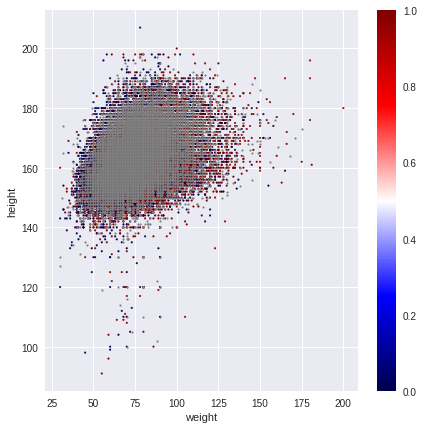

In [44]:
train, test = preprocess(train, test)

#### После преобразования возраста гистограмма выглядит покрасивей

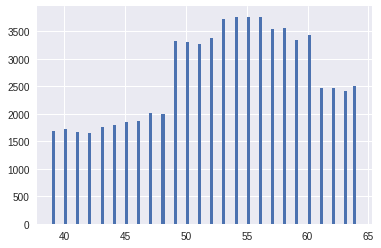

In [45]:
train.age.hist(bins=100)

#### Давление после чистки и округления выглядит вот так

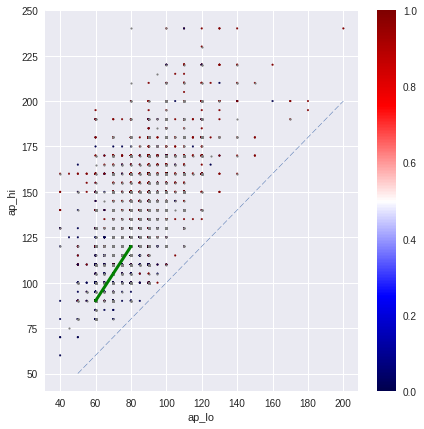

In [46]:
pl.figure(figsize=(7,7))
pl.scatter(train.ap_lo, train.ap_hi, s=3, c=y_train, cmap='seismic')
pl.colorbar()
pl.scatter(test.ap_lo, test.ap_hi, s=3, c='grey')
pl.plot([50, 200], [50, 200], '--', linewidth=0.5)
pl.plot([60, 80], [90, 120], color='g', linewidth=3)
pl.xlabel('ap_lo')
pl.ylabel('ap_hi')

In [47]:
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=5)

In [55]:
def getNewFeaturesXGB(max_depth=4, learning_rate=0.02, n_estimators=791,
                      reg_lambda=6.2, reg_alpha=0.6288, subsample=0.8019,
                      colsample_bylevel=0.6983, colsample_bytree=0.7464,
                      gamma=0.9215, min_child_weight=6.2515, max_delta_step=1.6275,
                      seed=5, nthread=-1):
    return xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                             colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, reg_alpha=reg_alpha,
                             reg_lambda=reg_lambda, min_child_weight=min_child_weight, subsample=subsample, gamma=gamma,
                             max_delta_step=max_delta_step, seed=seed, nthread=nthread)

def getStriveXGB(max_depth=5, learning_rate=0.01, n_estimators=967,
                      reg_lambda=6.1979, reg_alpha=1.845, subsample=0.8543,
                      colsample_bylevel=0.773, colsample_bytree=0.924,
                      gamma=1.2, min_child_weight=7.6, max_delta_step=0.6089,
                      seed=5, nthread=-1):
    return xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                             colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, reg_alpha=reg_alpha,
                             reg_lambda=reg_lambda, min_child_weight=min_child_weight, subsample=subsample, gamma=gamma,
                             max_delta_step=max_delta_step, seed=seed, nthread=nthread)

# For predicting active-smoke-alco. 
def getOpinionClassifier(max_depth=5, learning_rate=0.05, n_estimators=178,
                     colsample_bytree=0.95, colsample_bylevel=0.83, reg_alpha=0.2298,
                     reg_lambda=8.2013, min_child_weight=1, subsample=0.8503, gamma=0,
                     seed=5, nthread=-1):
    return xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                             colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, reg_alpha=reg_alpha,
                             reg_lambda=reg_lambda, min_child_weight=min_child_weight, subsample=subsample, gamma=gamma,
                             seed=seed, nthread=nthread)

In [49]:
def nan_for_all(data, fraction=0.1, seed=5):
    if 'smoke' not in data.columns:
        return data
    np.random.seed(seed)
    copy = data.copy()
    copy.reset_index(drop=True, inplace=True)
    copy.loc[np.random.randint(0, copy.shape[0], size=int(copy.shape[0]*fraction)), 'smoke'] = np.NaN
    copy.loc[np.random.randint(0, copy.shape[0], size=int(copy.shape[0]*fraction)), 'alco'] = np.NaN
    copy.loc[np.random.randint(0, copy.shape[0], size=int(copy.shape[0]*fraction)), 'active'] = np.NaN
    return copy

def plot_feature_importance(clf, columns):
    pd.Series(clf.feature_importances_, index=list(columns)).sort_values(ascending=False).plot(kind='bar')
    
def overall_score(cv_scores, public_score):
    scores = np.append(cv_scores, [public_score])
    print('mean =', scores.mean(), 'std =', scores.std(), 'upper =', scores.mean() + scores.std(),
          'weighted mean =', ((cv_scores*6).sum() + public_score*7)/(6*7 + 7))

#### Кросс-валидация с применением различных стратегий по работе с пропущенными значениями. Лучшая стратегия  (train_nan) - в обучающей выборке скрыть 10% в полях smoke, alco, active, т.е. сделать более приближенным к тестовым данным.

In [50]:
def cross_val_score_nan(clf, train, y_train, nan_strategy='train_nan', scoring='neg_log_loss', weights_strategy=None,
                        prior_probas=False, cv=kf, scale=False, cut=0):
    assert nan_strategy in {'none', 'train_nan', 'predict_nan', 'probas'}
    if scale:
        assert nan_strategy in {'predict_nan', 'probas'}
        train = train.copy()
        scaler = StandardScaler()
        train.loc[:, :] = scaler.fit_transform(train)
    scores = []
    for train_index, validation_index in kf.split(train, y_train):
        if weights_strategy == 'knn':
            knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
            scaler = StandardScaler()
            proximity_columns = ['age', 'weight', 'height', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
            knn.fit(scaler.fit_transform(train[proximity_columns].iloc[train_index].append(train[proximity_columns].iloc[validation_index])),
                    [0]*train_index.shape[0] + [1]*validation_index.shape[0])
            weights = np.minimum(1, knn.predict_proba(scaler.transform(train.iloc[train_index][proximity_columns]))[:, 1] + 0.8)
        else:
            weights = None
        if nan_strategy == 'none':
            clf.fit(train.iloc[train_index].values, y_train[train_index], sample_weight=weights)
        elif nan_strategy == 'train_nan':
            clf.fit(nan_for_all(train.iloc[train_index]).values, y_train[train_index], sample_weight=weights)
        else:
            smoke_clf = getOpinionClassifier()
            smoke_clf.fit(train.iloc[train_index].drop('smoke', axis=1), train.iloc[train_index].smoke)
            alco_clf = getOpinionClassifier()
            alco_clf.fit(train.iloc[train_index].drop('alco', axis=1), train.iloc[train_index].alco)
            active_clf = getOpinionClassifier()
            active_clf.fit(train.iloc[train_index].drop('active', axis=1), train.iloc[train_index].active)
            if nan_strategy == 'probas':
                data = train.iloc[train_index].copy()
                smoke_values = smoke_clf.predict_proba(data.drop('smoke', axis=1))[:, 1]
                alco_values = alco_clf.predict_proba(data.drop('alco', axis=1))[:, 1]
                active_values = active_clf.predict_proba(data.drop('active', axis=1))[:, 1]
                data['smoke_proba'], data['alco_proba'], data['active_proba'] = smoke_values, alco_values, active_values
                clf.fit(data.values, y_train[train_index], sample_weight=weights)
                del data
            elif nan_strategy == 'predict_nan':
                clf.fit(train.iloc[train_index].values, y_train[train_index], sample_weight=weights)
    
        # Prediction
        data = nan_for_all(train.iloc[validation_index])
        if nan_strategy == 'predict_nan':
            smoke_values = smoke_clf.predict(data[data.smoke.isnull()].drop('smoke', axis=1))
            alco_values = alco_clf.predict(data[data.alco.isnull()].drop('alco', axis=1))
            active_values = active_clf.predict(data[data.active.isnull()].drop('active', axis=1))
            data.loc[data.smoke.isnull(), 'smoke'] = smoke_values
            data.loc[data.alco.isnull(), 'alco'] = alco_values
            data.loc[data.active.isnull(), 'active'] = active_values
            del smoke_values, alco_values, active_values
        elif nan_strategy == 'probas':
            smoke_values = smoke_clf.predict_proba(data.drop('smoke', axis=1))[:, 1]
            alco_values = alco_clf.predict_proba(data.drop('alco', axis=1))[:, 1]
            active_values = active_clf.predict_proba(data.drop('active', axis=1))[:, 1]
            data['smoke_proba'], data['alco_proba'], data['active_proba'] = smoke_values, alco_values, active_values
            del smoke_values, alco_values, active_values
        probas = clf.predict_proba(data.values)[:, 1]
        if prior_probas:
            probas = convert_probabilities(probas, prior=y_train[validation_index].sum()/validation_index.shape[0])
        if cut > 0:
            probas[probas < cut] = cut
        scores.append(log_loss(y_train[validation_index], probas))
        gc.collect()
    return -np.array(scores)

## Cross-validation

#### Кросс-валидация для лучшей модели XGB (глубина деревьев = 4), и важность признаков

[ 0.54106283  0.53330993  0.53568955  0.53320672  0.54542074  0.5326314
  0.53899495] 0.537188015793 +- 0.00447142391647 upper = 0.54165943971


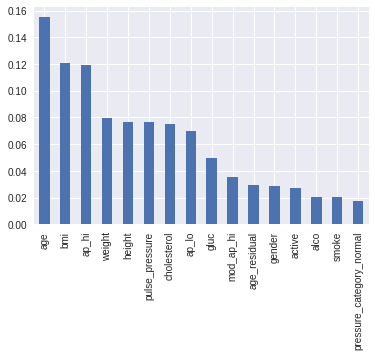

In [56]:
clf = getNewFeaturesXGB()
scores = -cross_val_score_nan(clf, train, y_train, nan_strategy='train_nan', scoring='neg_log_loss', cv=kf)
print(scores, scores.mean(), '+-', scores.std(), 'upper =', scores.mean() + scores.std())
clf.fit(train, y_train)
plot_feature_importance(clf, train.columns)

#### Среднее двух XGB (с глубиной 4 и 5).

In [57]:
clf = VotingClassifier([
        ('feat', getNewFeaturesXGB()),
        ('strive', getStriveXGB())], voting='soft')
scores = -cross_val_score_nan(clf, train, y_train, nan_strategy='train_nan', scoring='neg_log_loss', cv=kf)
print(scores, scores.mean(), '+-', scores.std(), 'upper =', scores.mean() + scores.std())

[ 0.54092543  0.53300627  0.53547598  0.53296683  0.54538489  0.53251748
  0.53902679] 0.537043381165 +- 0.00454253109306 upper = 0.541585912258


#### Оценка качества, используя результат на публичном лидерборде

In [58]:
overall_score(scores, 0.5431460)

mean = 0.537806208519 std = 0.00470410503161 upper = 0.542510313551 weighted mean = 0.537915183855


### Предсказание для всех тестовых данных

#### с предварительным сокрытием 10% у smoke, alco, active в обучающей выборке

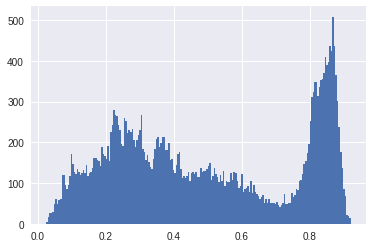

In [59]:
clf.fit(nan_for_all(train), y_train)
y_pred = clf.predict_proba(test)[:, 1]
pl.hist(y_pred, bins=200)
np.savetxt('submission_voting_train_nan.csv', y_pred, fmt='%.6f')

### Усреднение двух моделей XGB давало 0.5431460 на публичном сете, но на финальном показало 0.5305696 (соответствует второму месту)

### Этап очистки, дискретизация признаков, стратегия работы с пропущенными значениями, и два XGB с хорошими гиперпараметрами образовали отличное решение для дальнейшего смешивания с лучшими предыдущими сабмитами. Усреднение своих лучших сабмитов дало прирост на публичном лидерборде, однако, финальный результат блендинга 0.5304688 соответствует тому же второму месту.